# Import Modules

In [1]:
import requests
from tqdm import tqdm
import os; import glob; import shutil
import random as r
import json
import pickle
from itertools import islice
import matplotlib.pyplot as plt
import tempfile
from concurrent.futures import ProcessPoolExecutor
from dataclasses import dataclass
import sys
import math
import bisect

import torch
from torch import (
    nn,
    Tensor
)
import torch.nn.functional as F
import torchaudio

print("Torch Version:", torch.__version__)
print("TorchAudio Version:", torchaudio.__version__)

Torch Version: 2.2.1+cu121
TorchAudio Version: 2.2.1+cu121


# Pretrained Models: Encodec and T5 Model

In [2]:
from encodec import (
    EncodecModel,
    utils as enc_utils
)
from transformers import AutoTokenizer, T5EncoderModel

encodec_model = EncodecModel.encodec_model_24khz()
encodec_model.set_target_bandwidth(3.0) # 3 kbps (n_q = 4)
SRATE = encodec_model.sample_rate
MAX_SEC = 10
WAVLEN = SRATE*MAX_SEC

## (google-t5/t5-small) (google-t5/t5-base) (google-t5/t5-large) (google-t5/t5-3b) (google-t5/t5-11b)
T5_MODEL_PATH = "google-t5/t5-small"
# t5_model = T5EncoderModel.from_pretrained(T5_MODEL_PATH)
t5_tokenizer = AutoTokenizer.from_pretrained(T5_MODEL_PATH)

/home/vvy/Desktop/repos/MAGNeT/.venv/lib/python3.11/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


In [3]:
def preprocess_wavpath(wavpath:str):    
    wav, sr = torchaudio.load(wavpath)
    wav = enc_utils.convert_audio(
            wav, sr=sr, target_sr=SRATE,
            target_channels=encodec_model.channels
        )
    
    return wav

# Dataset
### Music Bench (Dataset details):
* 52,768 training and 400 test samples
* Including music features of chords, beats, tempo, and key that are extracted from the audio.
* Describing these music features using text templates and thus enhancing the original text prompts.

Each row of a .json file has:
* `location` (of the files after decompressing the .tar.gz file)
* `main_caption` – text prompts that are a result of augmentation (TestB contains control sentences, train set contains ChatGPT rephrased captions here)
* `alt_caption` – in the case of TestB these are captions without any control sentences added.
* `prompt_aug` – A control sentence related to volume change augmentation.
* `prompt_ch` – A control sentence describing the chord sequence.
* `prompt_bt` – A control sentence describing the beat count (meter)
* `prompt_bpm` – A control sentence describing tempo, either in beats per minute (bpm), or in musical words, e.g., Adagio, Moderato, Presto.
* `prompt_key` – A control sentence related to the extracted musical key.
* `beats` – The beat and downbeat timestamps. This is used as an input for training Mustango.
* `bpm` – The tempo feature saved as a number.
* `chords` – The chord sequence contained in the track. This is used as an input for training Mustango.
* `chords_time` – Timestamps of the detected chords. This is used as an input for training Mustango.
* `key` – The root and the type of the detected key.
* `keyprob` – The confidence score for this detected key provided by the detection algorithm.

In [4]:
def playAudio(
        filepath:str=None,
        tensor:Tensor=None,
        text:str=None,
        save:bool=False,
        sample_rate:int=16_000,
        show:bool=False
    ):
    assert any([filepath, tensor is not None]), "provide either wav-path or a wav-tensor of shape 2"
    if text is not None:
        print("Prompt:", text, sep="\n")
    if filepath:
        assert filepath.endswith(".wav")
        if show:
            wav = torchaudio.load(filepath)[0][0]
            plt.plot(wav.tolist()); plt.show()
        os.system(f'aplay {filepath}')
    elif tensor is not None:
        if save:
            assert filepath is not None, "provide filepath if you want to save"
            torchaudio.save(filepath, src=tensor)
            playAudio(filepath, tensor=None, show=show)
        else:
            with tempfile.NamedTemporaryFile(suffix=".wav") as tmp:
                torchaudio.save(tmp.name, src=tensor.unsqueeze(0), sample_rate=sample_rate)
                playAudio(tmp.name, tensor=None, show=show)

In [5]:
DATA_DIR = "data/MusicBench"
URLS = [
    "https://huggingface.co/datasets/amaai-lab/MusicBench/resolve/main/MusicBench_train.json"
    "https://huggingface.co/datasets/amaai-lab/MusicBench/resolve/main/MusicBench_test_A.json",
    "https://huggingface.co/datasets/amaai-lab/MusicBench/resolve/main/MusicBench_test_B.json",
    "https://huggingface.co/datasets/amaai-lab/MusicBench/resolve/main/MusicBench.tar.gz",
]
FILE_PATHS:list[str] = [os.path.join(DATA_DIR, url.split("/")[-1]) for url in URLS]

DATA_PATH = os.path.join(DATA_DIR, "datashare/data_aug2")
AUDIO_TXT_PATH = os.path.join(DATA_DIR, "audiopath_txt.pkl")

## File Utils

In [6]:
def download_file(url:str, filename:str, chunk_size:int=1024):
    """Download a file from the given URL and save it with the specified filename"""
    resp = requests.get(url, stream=True)
    total = int(resp.headers.get("content-length", 0))
    with open(filename, "wb") as file, tqdm(
        desc=filename,
        total=total,
        unit="iB",
        unit_scale=True,
        unit_divisor=1024,
    ) as bar:
        for data in resp.iter_content(chunk_size=chunk_size):
            size = file.write(data)
            bar.update(size)

    print(f"{filename} downloaded successfully:")

## Download Dataset

In [7]:
def download_dataset():
    "download if data dir is empty"
    os.makedirs(DATA_DIR, exist_ok=True)

    # if files not present in DATA_DIR then start downloading
    if not os.listdir(DATA_DIR):
        # download files
        for url, file_path in zip(URLS, FILE_PATHS):
            # if that file doesn't exist then only downloading else skip downloading
            if not os.path.exists(file_path):
                try:
                    # the tar file is very big so may freeze download in-between. 
                    download_file(url, file_path)
                except: # KeyboardInterrupt download freezes
                    print(f"Couldn't download {file_path}. So deleting that file, try again. Maybe try manually downloading it")
                    os.remove(file_path)
                # if file is a .tar.gz type unpack it
                if file_path.endswith(".tar.gz"):
                    print(f"Unpacking {file_path}")
                    return_code = os.system(f"tar -xzf {file_path} -C {DATA_DIR}")
                    print(
                        "Unpacking succesful," if return_code==0 else 
                        f"Error code {return_code} when unpacking {file_path}"
                    )
            else:
                print(f"{file_path} is present, skipping downloading it.")
        
        # move unpacked files from diff folder to the one folder and delete src folder
        src_dir = "data/MusicBench/datashare/data"
        for fpath in os.listdir(src_dir):
            fpath = os.path.join(src_dir, fpath)
            shutil.move(src=fpath, dst=DATA_PATH)
        print(f"Moved files from {src_dir} to {DATA_PATH} so deleting {src_dir}")
        os.removedirs(src_dir)

# download_dataset()

## Save and load dataset

In [8]:
def shuffle_preserve_order(a, b):
    combined = list(zip(a, b))
    r.shuffle(combined)

    a, b = zip(*combined)
    return a, b

In [9]:
def ioPathTextDs(
    save_path:str, 
    batch_size:int|None=None, 
    return_outputs:bool=True,
) -> list[tuple[str, str]]|None:
    if not os.path.exists(save_path):
        print("Saving dataset...")
        assert batch_size is not None, "provide batch_size when saving."
        paths, texts = [], []
        with open('data/MusicBench/MusicBench_train_modified.json') as json_data:
            for line in json_data:
                # convert "string-dictionary" to dictionary
                data:dict[str, str] = json.loads(line.replace("'", "/"))
                # data dictionary with music file path and text caption for that music             
                wavpath, text = (data["location"], data["main_caption"])
                if not wavpath.split("/")[0].endswith("_aug2"):
                    dirname, filename = wavpath.split("/")
                    wavpath = os.path.join(dirname + "_aug2", filename)
                wavpath = os.path.join(DATA_DIR, "datashare", wavpath)
                paths.append(wavpath); texts.append(text)
        assert len(paths)==len(texts), "Number of audio paths must be equal to number of captions"
        print("Loaded paths and prompts...")
        # shuffle dataset
        paths, texts = shuffle_preserve_order(paths, texts)
        paths = [list(islice(paths, i, i+batch_size)) for i in range(0, len(paths), batch_size)][:-1] # (len//batch_size, batch_size)
        texts = [list(islice(texts, i, i+batch_size)) for i in range(0, len(texts), batch_size)][:-1] # (len//batch_size, batch_size)
        # save dataset
        with open(save_path, "wb") as file:
            pickle.dump(
                obj=[paths, texts], file=file,
                protocol=pickle.HIGHEST_PROTOCOL
            )
    else:
        # load dataset
        print("Loaded dataset.")
        with open(save_path, "rb") as file:
            paths, texts = pickle.load(file)
    
    if return_outputs:
        return paths, texts
    
paths, texts = ioPathTextDs(save_path=AUDIO_TXT_PATH, batch_size=32, return_outputs=True) # ~?mins

Loaded dataset.


## Feel the dataset

---
```python
for b_paths, b_texts in zip(paths[:2], texts[:2]):
    for i in range(32):
        playAudio(b_paths[i], text=b_texts[i], show=True)
```
---

---
```python
def num_seconds(paths):
    nSeconds = []
    for path in paths:
        wav, sr = torchaudio.load(path)
        nsec = wav.shape[-1]/sr
        nSeconds.append(nsec)
    return nSeconds
secs = torch.tensor(num_seconds([item for sublist in paths for item in sublist]))
print("Stats: ", secs.min(), secs.max(), secs.mean(), secs.std())

def freq(arr):
  frequency = {}
  for item in arr:
    if item in frequency:
        frequency[item] += 1
    else:
        frequency[item] = 1
  return frequency
sec_freqs = freq(secs.tolist())
s = dict(sorted(sec_freqs.items(), key=lambda x: x[0]))
frq = sorted(sec_freqs.values())
print(min(frq), max(frq))

fig, ax = plt.subplots()
plt.scatter(list(s), list(s.values()))
plt.xlabel("Number of seconds")
plt.ylabel("Frequencies")
plt.yticks(list(range(0, 50_000, 5_000)) + [1])
plt.grid(True)
ax.axhline(y=1, color='r', linestyle='dotted')
ax.text(9, 20, 'freq=1', verticalalignment='center', color='r')
plt.show()

Outputs:
Stats:  tensor(7.9034) tensor(10.) tensor(9.8095) tensor(0.5069)
1 44210
```

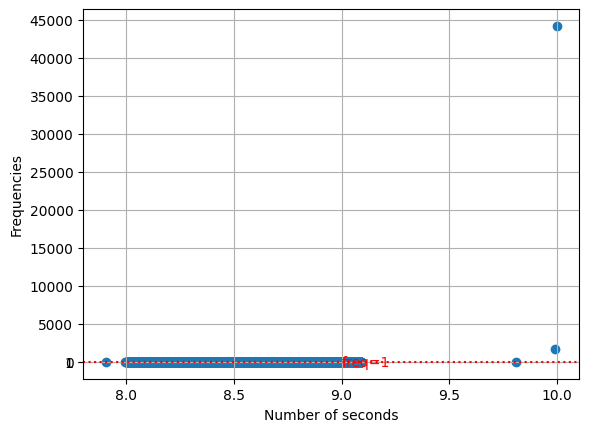

---

## Torch Dataset

In [10]:
class DataOp(torch.utils.data.IterableDataset):
    def __init__(self, split:str, batch_size:int):
        self.split = split
        self.batch_size = batch_size
        self.wav_paths, self.captions = ioPathTextDs(save_path=AUDIO_TXT_PATH, batch_size=batch_size) # (len//batch_size, batch_size), (len//batch_size, batch_size)

    @staticmethod
    def preprocess_batched_wavpath(bs_wavpaths):
        """pads to maxlen in batch, if less than WAVLEN pad again"""
        bs_wavs = nn.utils.rnn.pad_sequence(
            list(ProcessPoolExecutor.map(preprocess_wavpath, bs_wavpaths)), 
            batch_first=True
        )
        if bs_wavs.shape[-1] != WAVLEN: # 240_000
            bs_wavs = F.pad(bs_wavs, (0,WAVLEN - bs_wavs.shape[-1]))
        return bs_wavs

    def __iter__(self):
        while True:
            # shuffle the chunk without disturbing order of wav paths and texts
            # shape(batch_size)[path1, path2, ..., path32], [txt1, txt2, ..., txt32]
            for bs_wavpaths, bs_texts in shuffle_preserve_order(self.wav_paths, self.captions): 
                bs_wavs = DataOp.preprocess_batched_wavpath(bs_wavpaths)
                
                tokens_attmsk = t5_tokenizer( # {'input_ids': , ..., 'attention_mask': ...}
                    bs_texts, return_tensors="pt", padding=True
                )
                yield bs_wavs, tokens_attmsk


# normalize then pad to maximum length
"""print("Converting paths to wav tensors...")
with ProcessPoolExecutor() as executor:
    wavs = list(executor.map(preprocess_wavpath, paths))
print("Padding the wav tensors...")
wavs = nn.utils.rnn.pad_sequence(wavs, batch_first=True)
print("Wav dataset shape", wavs.shape)
wavs = wavs.tolist()"""
# batchify dataset and skip last partial batch

# TODO @ train loop
"""
with torch.no_grad():
    encoded_frames = model.encode(wav)
codes = torch.cat([encoded[0] for encoded in encoded_frames], dim=-1)  # [B, n_q, T]
    
outputs = model(input_ids=tokens_attmsk["input_ids"], attention_mask=tokens_attmsk["attention_mask"])
        
a = t5_tokenizer(
    ["Hey hi", "hi"], return_tensors="pt",
    padding=True
)
a["input_ids"], a["attention_mask"], a
"""


'\nwith torch.no_grad():\n    encoded_frames = model.encode(wav)\ncodes = torch.cat([encoded[0] for encoded in encoded_frames], dim=-1)  # [B, n_q, T]\n    \noutputs = model(input_ids=tokens_attmsk["input_ids"], attention_mask=tokens_attmsk["attention_mask"])\n        \na = t5_tokenizer(\n    ["Hey hi", "hi"], return_tensors="pt",\n    padding=True\n)\na["input_ids"], a["attention_mask"], a\n'

# Encodec Model

```python
Input to encodec (x): shape(C_a*T)
    T: d*f_s
    d: audio duration
    f_s: sampling frequency
Encoder Output:
    
Quantized repr: z ∈ {1,...,Nq}^(K*T)
    T: (d*f_r)
    d: audio duration
    f_r: frame_rate, f_r << f_s
    K: number of codebooks used in RVQ
    Nq: codebook size
```

* Recall, the audio representation is composed of multi-stream sequences created by RVQ. In which, the first codebook encodes the coarse information of the signal while later codebooks encode the quantization error to refine the generation quality
* To handle that, Borsos et al. (2023b) proposed to predict tokens from codebook k given its preceding codebooks. During training, a codebook level k, is being uniformly sampled from {1, . . . ,K}. Then, we mask and predict the tokens of the k-th codebook given previous levels via teacher forcing
* At inference, we sequentially generate the token streams, where each codebook is being generated conditioned on previously generated codebooks

In [11]:
def getQuantizedCodings(bs_waves:Tensor): # (B, C=1, T=WAVLEN)
    with torch.no_grad():
        encoded_frames = encodec_model.encode(bs_waves) 
    codes = encoded_frames[0][0] # (B, n_q=4, T=750)
    return codes

def getAudioFromCodings(codes:Tensor):
    encoded_frames = [(codes, None)]
    with torch.no_grad():
        wavs = encodec_model.decode(encoded_frames)
    return wavs

```python
wav = preprocess_wavpath(wavpath="data/MusicBench/datashare/data_aug2/_0-2meOf9qY_3.wav").unsqueeze(0)
playAudio(tensor=wav.squeeze(), sample_rate=SRATE, show=True) # wav
```
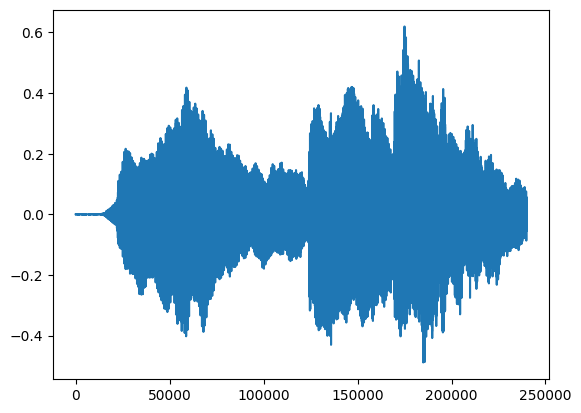

```python
qcodings = getQuantizedCodings(wav)
wav1 = getAudioFromCodings(qcodings)
playAudio(tensor=wav1.squeeze(), sample_rate=SRATE, show=True); print(wav1, wav1.shape) # decode(encode(wav))
```
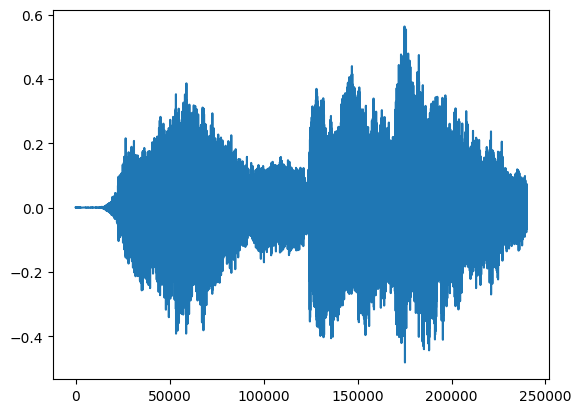

In [12]:
# wav = preprocess_wavpath(wavpath="data/MusicBench/datashare/data_aug2/_0-2meOf9qY_3.wav").unsqueeze(0)
# playAudio(tensor=wav.squeeze(), sample_rate=SRATE, show=True) # wav

In [13]:
# qcodings = getQuantizedCodings(wav); print("Quantized Codings:", qcodings.shape)
# wav1 = getAudioFromCodings(qcodings)
# playAudio(tensor=wav1.squeeze(), sample_rate=SRATE, show=True); print(wav1, wav1.shape)

In [14]:
# for code in qcodings[0]:
#     print(code.shape, code.max(), code.min())

# MAGNeT Comp Ops

## Masking Strategy
* Use spans of tokens as the atomic buildings blocks
* Using a ***span-length of 3*** *(after using encodec model not on raw wav tensor)*, which corresponds to spans of 60ms yields the best performance
* Masking rate `gamma(i)` from the scheduler and compute the average amount of spans to be masked
* `gamma(i;s) = cos(pi*(i-1)/2s)`
* Spans overlap so it's important to design `u (number of spans to mask)` carefully
* Choose ![Screenshot from 2024-04-10 17-44-16.png](<attachment:Screenshot from 2024-04-10 17-44-16.png>)
* `j` is index to be masked, `i` is current index
---
* 
    ```python
    [i.tolist().count(True) for i in m_init.numpy()]
    [414, 248, 151, 16, 18, 380, 202, 147, 75, 402, 319, 343, 207,136, 184, 278, 
     91, 43, 132, 54, 104, 13, 493, 81, 265, 63, 121, 361, 171, 66, 304, 237]

    [i.tolist().count(True) for i in mask.numpy()]
    [670, 518, 371, 48, 52, 666, 454, 361, 204, 668, 609, 620, 475, 327, 418, 565,
    254, 122, 328, 142, 269, 39, 716, 214, 552, 164, 310, 643, 392, 183, 603, 491]
    ```
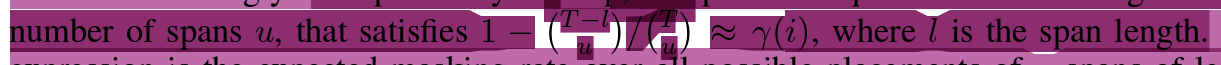

In [15]:
T = 750 # length after encodec model # seq len
L = 3 # mask span length # mask_span len
s = 20 # number of decoding steps # num_decoding_steps

In [16]:
def getNumberOfSpansToMask(T:int, L:int):
    """
    ### Docs for how to use output 
    ```
    We need something sort of like this {0: 0, 0.01: 3, ..., 0.99: 588, 1.0: 748} (mask_rate:u) but
    [0, 3, ..., 588, 748] <= num_spans_to_mask (output)
    [0, 1, ..., 99 , 100] <= corresponding indexes of num_spans_to_mask (mask_rate*100)
    so no need of a dictionary like above
    ```"""
    approx_maskrate_given_u = lambda u: 1 - math.comb(T-L, u)/math.comb(T, u) # LHS
    approx_mask_rates = [approx_maskrate_given_u(u) for u in range(0, T)]
    
    # get mean number of spans to mask (u) given maskrate ([i/100 for i in range(100+1)])
    num_spans_to_mask = []
    for mask_percentage in range(100+1):
        mask_rate = mask_percentage/100 # dummy mask rates
        # Return the index where to insert mask_rate in approx_mask_rates (sorted) to keep it sorted
        u = bisect.bisect_left(approx_mask_rates, mask_rate)
        num_spans_to_mask.append(u)
    return num_spans_to_mask # (100,)

In [17]:
print([mask_percentage/100 for mask_percentage in range(100+1)])

[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.0]


In [34]:
def maskSpans(mask_rates:Tensor, T:int, l:int):
    """```
    Args:
        mask_rates: Tensor => mask_probabilities of shape (B,)
        T: int => length of Sequence
        l: int => span length
    Returns:
        mask: Tensor => mask of shape (B, T)
    ```"""
    B = len(mask_rates)

    indexes = torch.round(mask_rates*100) # indexes to take from num_spans_to_mask # (B,)
    # contains number of spans to mask
    batched_num_spans = torch.tensor(
        getNumberOfSpansToMask(T, L=3)).gather(dim=0, index=torch.tensor(indexes)).clip(min=1) 
    # (100,) =[indexes]=> (B,) # Using gather ensures support when len(indexes) > 100
    
    batch_randperm = torch.rand((B, T)).argsort(-1) # rand integers
    mask = batch_randperm < batched_num_spans[..., None] # contains batched_num_spans number of Trues
    shifted_mask = mask.detach().clone()
    for _ in range(l-1):
        shifted_mask = torch.concat((torch.full((B, 1), False), shifted_mask[:, :-1]), dim=-1)
        mask = torch.logical_or(mask, shifted_mask)
    return mask

In [33]:
torch.tensor(getNumberOfSpansToMask(T, L=3)).gather(dim=0, index=torch.tensor(indexes)).clip(min=1)

tensor([414, 248, 151,  16,  18, 380, 202, 147,  75, 402, 319, 343, 207, 136,
        184, 278,  91,  43, 132,  54, 104,  13, 493,  81, 265,  63, 121, 361,
        171,  66, 304, 237])

In [ ]:
@dataclass
class config:
    seqlen:int
    spanlen:int

In [19]:
detachindexes = r.sample(list(range(100)), 32)
k1 = torch.tensor(getNumberOfSpansToMask(T, L=3))[indexes].clip(min=1) # []
k1, k1.shape

(tensor([414, 248, 151,  16,  18, 380, 202, 147,  75, 402, 319, 343, 207, 136,
         184, 278,  91,  43, 132,  54, 104,  13, 493,  81, 265,  63, 121, 361,
         171,  66, 304, 237]),
 torch.Size([32]))

In [20]:
batch_randperm = torch.rand((32, T)).argsordetacht(-1) #; print(batch_randperm, k1[..., None], batch_randperm.shape, sep="\n")

In [29]:
mask = batch_randperm < k1[..., None]; m_init = mask.clone()
shifted_mask = mask.clone()
for _ in range(3-1):
    shifted_mask = torch.concat((torch.full((32, 1), False), shifted_mask[:, :-1]), dim=-1)
    mask = torch.logical_or(mask, shifted_mask)
mask, (mask==m_init).all()

(tensor([[ True,  True,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True, False],
         [False, False,  True,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ...,  True, False, False],
         [False, False,  True,  ..., False,  True,  True]]),
 tensor(False))

In [28]:
mask = batch_randperm < k1[..., None]; m_init = mask.clone()
shifted_mask = mask.clone()
for _ in range(3 - 1):
    shifted_mask = torch.concat((torch.full((32, 1), False), shifted_mask[:, :-1]), dim=-1)
    mask = torch.logical_or(mask, shifted_mask)
mask, (mask==m_init).all()

(tensor([[ True,  True,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True, False],
         [False, False,  True,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ...,  True, False, False],
         [False, False,  True,  ..., False,  True,  True]]),
 tensor(False))

In [28]:
brand_perm = torch.rand((2, 10)).argsort(-1); print(brand_perm)
k = torch.tensor(
    [[5],
     [7]]
)

m = brand_perm < k
m # contains k number of Trues

tensor([[8, 2, 1, 5, 4, 0, 3, 7, 6, 9],
        [8, 1, 7, 0, 4, 2, 9, 3, 5, 6]])


tensor([[False,  True,  True, False,  True,  True,  True, False, False, False],
        [False,  True, False,  True,  True,  True, False,  True,  True,  True]])

In [29]:
sm = m.clone()
for i in range(3-1):
    sm = torch.concat((torch.full((2, 1), False), sm[:, :-1]), dim=-1)
    print(i, sm, "\n", m)
    m = torch.logical_or(m, sm)
    print(i, m)
    print("\n\n")

0 tensor([[False, False,  True,  True, False,  True,  True,  True, False, False],
        [False, False,  True, False,  True,  True,  True, False,  True,  True]]) 
 tensor([[False,  True,  True, False,  True,  True,  True, False, False, False],
        [False,  True, False,  True,  True,  True, False,  True,  True,  True]])
0 tensor([[False,  True,  True,  True,  True,  True,  True,  True, False, False],
        [False,  True,  True,  True,  True,  True,  True,  True,  True,  True]])



1 tensor([[False, False, False,  True,  True, False,  True,  True,  True, False],
        [False, False, False,  True, False,  True,  True,  True, False,  True]]) 
 tensor([[False,  True,  True,  True,  True,  True,  True,  True, False, False],
        [False,  True,  True,  True,  True,  True,  True,  True,  True,  True]])
1 tensor([[False,  True,  True,  True,  True,  True,  True,  True,  True, False],
        [False,  True,  True,  True,  True,  True,  True,  True,  True,  True]])





In [30]:
m

tensor([[False,  True,  True,  True,  True,  True,  True,  True,  True, False],
        [False,  True,  True,  True,  True,  True,  True,  True,  True,  True]])

In [ ]:
torch.tensor(getNumberOfSpansToMask(T, L=3))[[mask_percentage for mask_percentage in range(100+1)]].clip(min=1) # (B,)

In [ ]:
torch.rand((2, 750)).argsort(dim=-1)

In [ ]:
print(getNumberOfSpansToMask(T, L))

In [ ]:
torch.tensor(getNumberOfSpansToMask(T, L))*3

In [ ]:
def getMask(l:int): # tensor: shape(B, nq, T) # shape(B, nq=4, T=750)
    pass

## Restricted Context

## Classifier-Free Guidance

## Model Ops

In [ ]:
class PositionalEmbedding:
    """```
    Sinusoidal Fixed Positional Embeddings
    Args:
        maxlen:int
        dim:int
    sinusoidal_embeddings: 
        pos_emb: (1, maxlen, dim)
    ```"""
    def __init__(self, maxlen:int, dim:int):
        p, i = torch.meshgrid(torch.arange(float(maxlen)), torch.arange(dim/2)*2)
        theta = (p/1e4**(i/dim)).T
    
        self.pos_emb = torch.stack([torch.sin(theta), torch.cos(theta)], axis=-1)
        self.pos_emb = self.pos_emb.reshape((maxlen, dim))[None] # (1, maxlen, dim)
    
    def sinusoidal_embeddings(self):
        return self.pos_emb # (1, maxlen, dim)

## Dumb model for dumb baselines

In [ ]:
class DModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.rnn = nn.LSTM(
            input_size=config.d_model, # input dim
            hidden_size=config.d_model, # output dim
            num_layers=config.num_layers,
            batch_first=True,
            bidirectional=True
        )

    def forward(self, x): # (B, T, d_model)
        return self.rnn(x) # (B, T, d_model)

## MAGNeT-Transformer Model

## Magnet - Model Agnostic

In [ ]:
class MAGNET(nn.Module):
    def __init__(self, model, config):
        self.model = model
        self.embs = [nn.Embedding(
            num_embeddings=config.cardinality, # C
            embedding_dim=config.d_model
        ) for _ in range(config.num_codebooks)]

        self.nq = config.num_codebooks # nq

    def forward(self, x): # (B, nq, C)
        x = sum([self.embs[codebook](x[:, codebook]) for codebook in range(self.nq)]) # (B, S, )

# Model Agnostic Train Loop

In [ ]:
class MagnetTrainer:
    def __init__(self, config:config):
        self.__num_spans_to_mask = torch.tensor(
            self._get_number_of_spans_to_mask(config.seqlen, config.spanlen)
        )

    def _get_number_of_spans_to_mask(self, T:int, L:int):
        """
        ### Docs for how to use output
        ```
        We need something sort of like this {0: 0, 0.01: 3, ..., 0.99: 588, 1.0: 748} (mask_rate:u) but
        [0, 3, ..., 588, 748] <= num_spans_to_mask (output)
        [0, 1, ..., 99 , 100] <= corresponding indexes of num_spans_to_mask (mask_rate*100)
        so no need of a dictionary like above
        ```"""
        approx_maskrate_given_u = lambda u: 1 - math.comb(T-L, u)/math.comb(T, u) # LHS
        approx_mask_rates = [approx_maskrate_given_u(u) for u in range(0, T)]
        
        # get mean number of spans to mask (u) given maskrate ([i/100 for i in range(100+1)])
        num_spans_to_mask = []
        for mask_percentage in range(100+1):
            mask_rate = mask_percentage/100 # dummy mask rates
            # Return the index where to insert mask_rate in approx_mask_rates (sorted) to keep it sorted
            u = bisect.bisect_left(approx_mask_rates, mask_rate)
            num_spans_to_mask.append(u)
        return num_spans_to_mask # (100,)

    def _get_spanned_mask(self, mask_rates:Tensor, T:int, l:int):
        """```
        Args:
            mask_rates: Tensor => mask_probabilities of shape (B,)
            T: int => length of sequence
            l: int => span length
        Returns:
            mask: Tensor => mask of shape (B, T)
        ```"""
        B = len(mask_rates)

        indexes = torch.round(mask_rates*100) # indexes to take from num_spans_to_mask # (B,)
        # contains number of spans to mask
        batched_num_spans = torch.tensor(
            self.__num_spans_to_mask).gather(dim=0, index=torch.tensor(indexes)).clip(min=1) 
        
        batch_randperm = torch.rand((B, T)).argsort(-1) # rand integers from 0 to T
        mask = batch_randperm < batched_num_spans[..., None] # contains batched_num_spans number of Trues
        shifted_mask = mask.clone()
        for _ in range(l-1):
            shifted_mask = torch.concat((torch.full((B, 1), False), shifted_mask[:, :-1]), dim=-1)
            mask = torch.logical_or(mask, shifted_mask)
        return mask
    
    def _magnet_restricted_att_mask(self):
        pass

    def _cfg(self):
        pass

    def _magnet_cross_entropy(self):
        pass

    def train_step(self):
        pass